In [438]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [439]:
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [440]:
df_news=pd.read_json('/content/drive/MyDrive/headlines.json',convert_dates=['Date'])

In [441]:
df_news=pd.DataFrame.from_records(df_news['news'])

In [442]:
df_news.head()

,Date,headlines
0,2011-01-01,"Transporters threaten protest, hike in fares.P..."
1,2011-01-02,Power sector’s payables cross Rs275bn mark.No ...
2,2011-01-03,Sui cantonment turned into military college.De...
3,2011-01-04,"Big loss to progressive forces, says Sherry.Bl..."
4,2011-01-05,Naming new Punjab governor a test for Zardari....


In [443]:
df_news['Date']=pd.to_datetime(df_news['Date'])

In [444]:
df_news['Date']=df_news['Date'].dt.strftime('%d-%b-%Y')

In [445]:
df_bank=pd.read_csv('/content/drive/MyDrive/HBL_01012010_07062018.csv')

In [446]:
df_bank.head()

,Symbol,Date,Open,High,Low,Close,Volume
0,HBL,04-Jan-2010,123.40,124.70,123.20,123.79,121296
1,HBL,05-Jan-2010,124.50,128.00,124.31,127.40,866016
2,HBL,06-Jan-2010,128.25,129.99,127.41,128.00,926924
3,HBL,07-Jan-2010,128.49,134.40,127.67,133.61,3268357
4,HBL,08-Jan-2010,133.25,134.00,131.50,133.26,1042705


In [447]:
df_merged=df_bank.merge(df_news,on='Date')

In [448]:
df_merged.head()

,Symbol,Date,Open,High,Low,Close,Volume,headlines
0,HBL,03-Jan-2011,120.20,121.00,116.80,119.49,510969,Sui cantonment turned into military college.De...
1,HBL,04-Jan-2011,119.50,122.30,119.50,121.87,627959,"Big loss to progressive forces, says Sherry.Bl..."
2,HBL,05-Jan-2011,121.75,126.45,121.40,124.93,1506848,Naming new Punjab governor a test for Zardari....
3,HBL,06-Jan-2011,124.50,125.89,123.75,124.98,773913,Violence in Pakistan declines: US report.Power...
4,HBL,07-Jan-2011,125.84,126.06,124.69,124.99,376749,President vows to expose Taseer’s killers.Bena...


In [449]:
df_merged.shape

(1846, 8)

In [450]:
stock_data = df_merged

In [451]:
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data['subjectivity'] = ''
stock_data.head()

,Symbol,Date,Open,High,Low,Close,Volume,headlines,compound,negative,neutral,positive,subjectivity
0,HBL,03-Jan-2011,120.20,121.00,116.80,119.49,510969,Sui cantonment turned into military college.De...,,,,,
1,HBL,04-Jan-2011,119.50,122.30,119.50,121.87,627959,"Big loss to progressive forces, says Sherry.Bl...",,,,,
2,HBL,05-Jan-2011,121.75,126.45,121.40,124.93,1506848,Naming new Punjab governor a test for Zardari....,,,,,
3,HBL,06-Jan-2011,124.50,125.89,123.75,124.98,773913,Violence in Pakistan declines: US report.Power...,,,,,
4,HBL,07-Jan-2011,125.84,126.06,124.69,124.99,376749,President vows to expose Taseer’s killers.Bena...,,,,,


In [452]:
 import nltk
 nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [453]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
# instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()
# calculating sentiment scores
stock_data['compound'] = stock_data['headlines'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headlines'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headlines'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headlines'].apply(lambda x: sid.polarity_scores(x)['pos'])
# displaying the stock data
stock_data.head()

,Symbol,Date,Open,High,Low,Close,Volume,headlines,compound,negative,neutral,positive,subjectivity
0,HBL,03-Jan-2011,120.20,121.00,116.80,119.49,510969,Sui cantonment turned into military college.De...,-0.8934,0.172,0.746,0.082,
1,HBL,04-Jan-2011,119.50,122.30,119.50,121.87,627959,"Big loss to progressive forces, says Sherry.Bl...",-0.6996,0.133,0.806,0.060,
2,HBL,05-Jan-2011,121.75,126.45,121.40,124.93,1506848,Naming new Punjab governor a test for Zardari....,-0.9442,0.319,0.638,0.044,
3,HBL,06-Jan-2011,124.50,125.89,123.75,124.98,773913,Violence in Pakistan declines: US report.Power...,-0.7906,0.179,0.726,0.094,
4,HBL,07-Jan-2011,125.84,126.06,124.69,124.99,376749,President vows to expose Taseer’s killers.Bena...,-0.5859,0.140,0.766,0.094,


In [454]:
from textblob import TextBlob
def getsubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
stock_data['subjectivity'] = stock_data ['headlines'].apply(getsubjectivity)
stock_data.head()

,Symbol,Date,Open,High,Low,Close,Volume,headlines,compound,negative,neutral,positive,subjectivity
0,HBL,03-Jan-2011,120.20,121.00,116.80,119.49,510969,Sui cantonment turned into military college.De...,-0.8934,0.172,0.746,0.082,0.237500
1,HBL,04-Jan-2011,119.50,122.30,119.50,121.87,627959,"Big loss to progressive forces, says Sherry.Bl...",-0.6996,0.133,0.806,0.060,0.296667
2,HBL,05-Jan-2011,121.75,126.45,121.40,124.93,1506848,Naming new Punjab governor a test for Zardari....,-0.9442,0.319,0.638,0.044,0.257071
3,HBL,06-Jan-2011,124.50,125.89,123.75,124.98,773913,Violence in Pakistan declines: US report.Power...,-0.7906,0.179,0.726,0.094,0.541667
4,HBL,07-Jan-2011,125.84,126.06,124.69,124.99,376749,President vows to expose Taseer’s killers.Bena...,-0.5859,0.140,0.766,0.094,0.229630


In [455]:
# dropping the 'headline_text' which is unwanted now
stock_data.drop(['headlines'], inplace=True, axis=1)
stock_data.drop(['Symbol'], inplace=True, axis=1)
# rearranging the columns of the whole stock_data
stock_data = stock_data[['Open'	,'High',	'Low',	'Close',	'Volume','compound',	'negative',	'neutral'	,'positive',	'subjectivity']]

# set the index name
stock_data.index.name = 'Date'

# displaying the final stock_data
stock_data.head()

,Open,High,Low,Close,Volume,compound,negative,neutral,positive,subjectivity
Date,,,,,,,,,,
0,120.20,121.00,116.80,119.49,510969,-0.8934,0.172,0.746,0.082,0.237500
1,119.50,122.30,119.50,121.87,627959,-0.6996,0.133,0.806,0.060,0.296667
2,121.75,126.45,121.40,124.93,1506848,-0.9442,0.319,0.638,0.044,0.257071
3,124.50,125.89,123.75,124.98,773913,-0.7906,0.179,0.726,0.094,0.541667
4,125.84,126.06,124.69,124.99,376749,-0.5859,0.140,0.766,0.094,0.229630


In [456]:
# calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# using 90% of data for training
train_end = int(data_to_use*0.90)
total_data = len(stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 1660
Number of records in Test Data: 186


In [457]:
stock_data.head(1)

,Open,High,Low,Close,Volume,compound,negative,neutral,positive,subjectivity
Date,,,,,,,,,,
0,120.2,121.0,116.8,119.49,510969,-0.8934,0.172,0.746,0.082,0.2375


In [458]:
# predicting one step ahead
# steps_to_predict = 1

# capturing data to be used for each column
open_price = stock_data.iloc[start:total_data,0] #open
high = stock_data.iloc[start:total_data,1] #high
low = stock_data.iloc[start:total_data,2] #low
close_price = stock_data.iloc[start:total_data,3] #close
volume = stock_data.iloc[start:total_data,4] #volume
compound = stock_data.iloc[start:total_data,5] #compound
negative = stock_data.iloc[start:total_data,6] #negative
neutral = stock_data.iloc[start:total_data,7] #neutral
positive = stock_data.iloc[start:total_data,8] #positive
subjectivity = stock_data.iloc[start:total_data,9] #subjectivity

# printing close price
print("Close Price:")
close_price

Close Price:


Date
1       121.87
2       124.93
3       124.98
4       124.99
5       123.56
         ...  
1841    172.91
1842    174.80
1843    181.72
1844    189.47
1845    184.88
Name: Close, Length: 1845, dtype: float64

In [459]:
# # shifting next day close
# close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
data = pd.concat([close_price, compound , compound_shifted, negative, neutral,positive ,open_price, high, low, volume], axis=1)

# setting column names of the revised stock data
data.columns = ['close_price', 'compound', 'compound_shifted','negative', 'neutral','positive','open_price' ,'high', 'low', 'volume']

# dropping nulls
data = data.dropna()
data.head(10)

,close_price,compound,compound_shifted,negative,neutral,positive,open_price,high,low,volume
Date,,,,,,,,,,
1,121.87,-0.6996,-0.9442,0.133,0.806,0.060,119.50,122.30,119.50,627959
2,124.93,-0.9442,-0.7906,0.319,0.638,0.044,121.75,126.45,121.40,1506848
3,124.98,-0.7906,-0.5859,0.179,0.726,0.094,124.50,125.89,123.75,773913
4,124.99,-0.5859,-0.9723,0.140,0.766,0.094,125.84,126.06,124.69,376749
5,123.56,-0.9723,-0.9578,0.272,0.667,0.062,126.24,126.80,123.00,166214
6,123.01,-0.9578,-0.3818,0.225,0.674,0.101,123.61,124.50,122.75,329849
7,127.87,-0.3818,-0.7184,0.125,0.757,0.118,124.00,128.90,123.89,788687
8,127.60,-0.7184,-0.8720,0.121,0.783,0.096,128.70,128.97,126.25,156709
9,126.70,-0.8720,-0.5994,0.154,0.771,0.074,128.48,128.48,126.45,278339


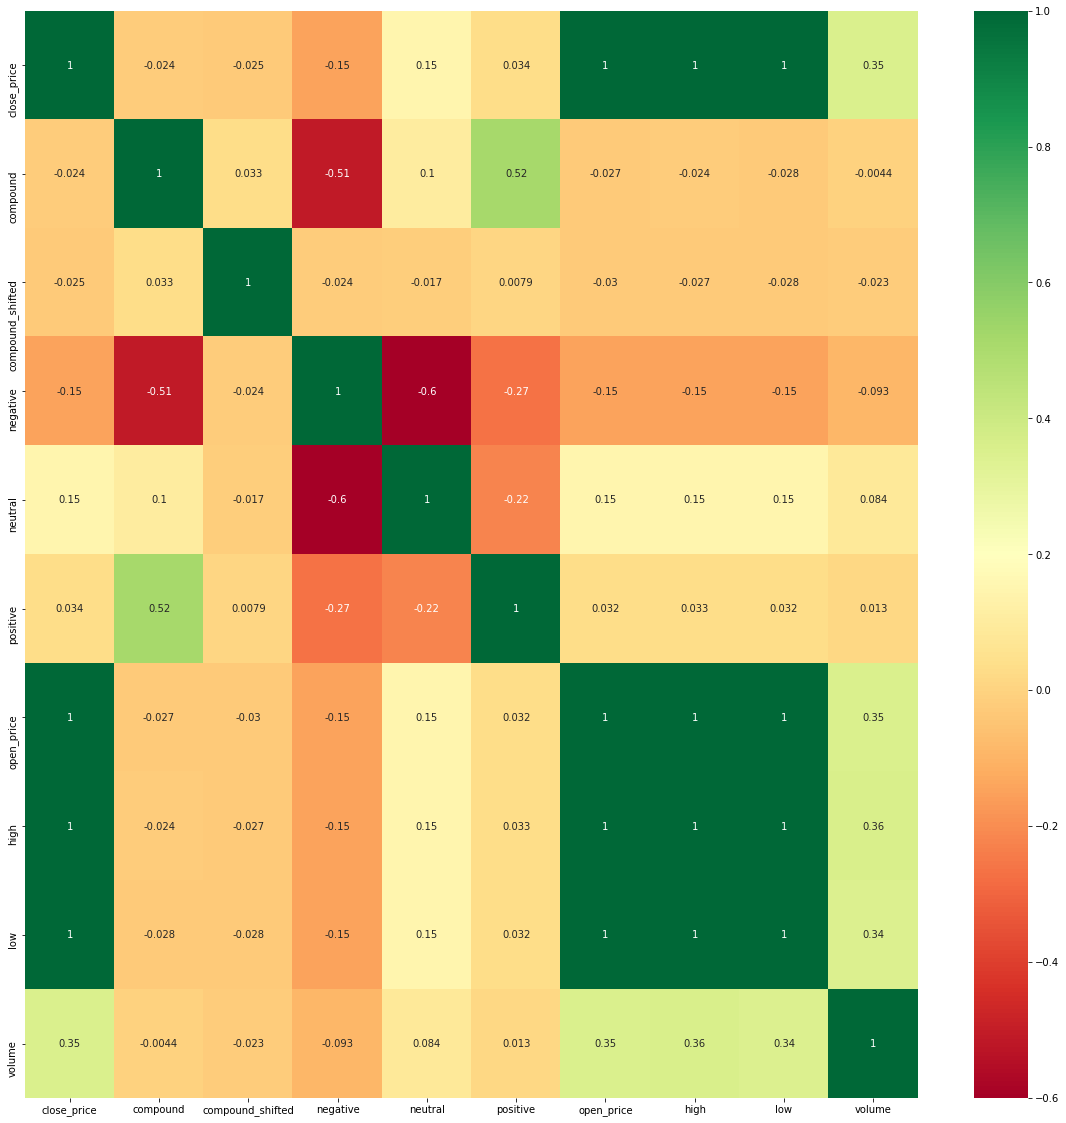

In [460]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [461]:
data.head(1)

,close_price,compound,compound_shifted,negative,neutral,positive,open_price,high,low,volume
Date,,,,,,,,,,
1,121.87,-0.6996,-0.9442,0.133,0.806,0.06,119.5,122.3,119.5,627959


In [603]:
# setting the features dataset for prediction  
cols = ['open_price' ,'high', 'low']
x = data[cols]
x

,open_price,high,low
Date,,,
1,119.50,122.30,119.50
2,121.75,126.45,121.40
3,124.50,125.89,123.75
4,125.84,126.06,124.69
5,126.24,126.80,123.00
...,...,...,...
1840,169.05,175.50,166.56
1841,165.00,174.25,165.00
1842,172.00,176.49,171.00


In [604]:
# setting the target variable as the shifted close_price
y = data['close_price']
y

Date
1       121.87
2       124.93
3       124.98
4       124.99
5       123.56
         ...  
1840    171.19
1841    172.91
1842    174.80
1843    181.72
1844    189.47
Name: close_price, Length: 1844, dtype: float64

In [605]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

(array([[-0.71776375, -0.704     , -0.71135719],
        [-0.6974752 , -0.66711111, -0.69396907],
        [-0.67267809, -0.67208889, -0.67246271],
        ...,
        [-0.24436429, -0.22231111, -0.24004759],
        [-0.21731289, -0.15964444, -0.21240963],
        [-0.1632101 , -0.10453333, -0.15749977]]), array([[-0.69288661],
        [-0.66514032],
        [-0.66468695],
        ...,
        [-0.21294827],
        [-0.15020175],
        [-0.07992927]]))

In [606]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)

Number of rows and columns in the Training set X: (1660, 3) and y: (1660, 1)
Number of rows and columns in the Test set X: (183, 3) and y: (183, 1)


In [607]:
# reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (1660, 3, 1)
Shape of Test set X: (183, 3, 1)


In [608]:
np.random.seed(2016)
tf.random.set_seed(2016)
model=Sequential()
model.add(LSTM(5,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 5)                 140       
_________________________________________________________________
dropout_63 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [609]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
hist = model.fit(X_train, y_train, validation_split=0.1, epochs=8, batch_size=5, verbose=1)

Epoch 1/8
299/299 [==============================] - 3s 5ms/step - loss: 0.1512 - val_loss: 0.1021
Epoch 2/8
299/299 [==============================] - 1s 3ms/step - loss: 0.0257 - val_loss: 0.0325
Epoch 3/8
299/299 [==============================] - 1s 3ms/step - loss: 0.0178 - val_loss: 0.0252
Epoch 4/8
299/299 [==============================] - 1s 3ms/step - loss: 0.0141 - val_loss: 0.0219
Epoch 5/8
299/299 [==============================] - 1s 3ms/step - loss: 0.0119 - val_loss: 0.0166
Epoch 6/8
299/299 [==============================] - 1s 3ms/step - loss: 0.0105 - val_loss: 0.0142
Epoch 7/8
299/299 [==============================] - 1s 3ms/step - loss: 0.0116 - val_loss: 0.0121
Epoch 8/8
299/299 [==============================] - 1s 3ms/step - loss: 0.0099 - val_loss: 0.0098


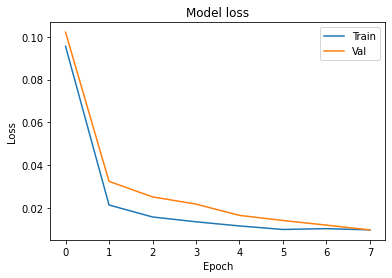

In [610]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [611]:
# performing predictions
predictions = model.predict(X_test) 

# unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[193.0412 ],
       [190.59637],
       [188.62709],
       [185.22253],
       [182.78316]], dtype=float32)

In [612]:
# calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

183/183 [==============================] - 0s 2ms/step - loss: 5.3460e-04
Train Loss = 0.0015
Test Loss = 0.0005


In [613]:
# unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

In [614]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 2.5499


In [691]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round((rmse),4))

Root Mean Square Error (sklearn.metrics) = 6.5022


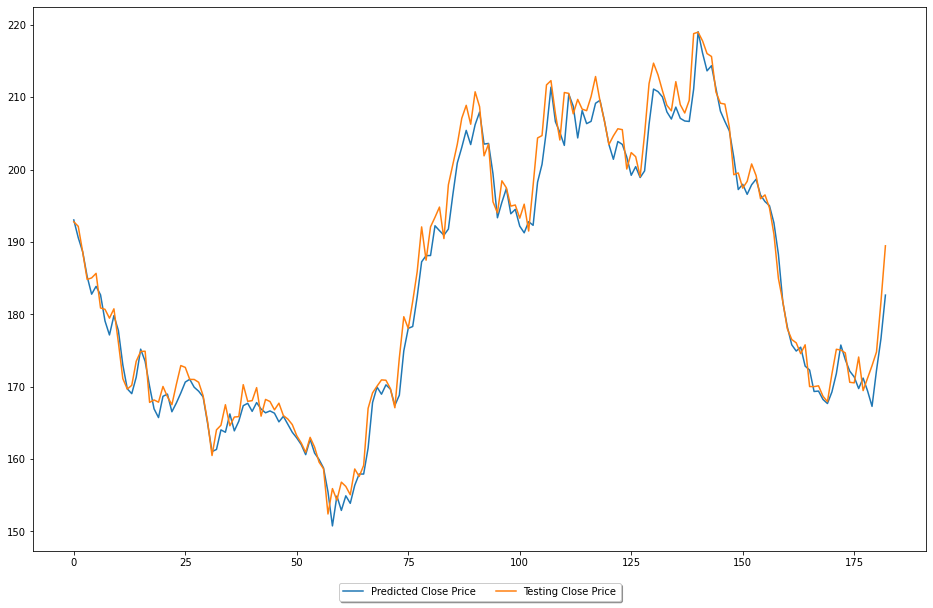

In [616]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()

In [617]:
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': predictions.flatten()})
df

,Actual,Predicted
0,192.79,193.041199
1,192.16,190.596375
2,188.60,188.627090
3,184.82,185.222534
4,185.03,182.783157
...,...,...
178,171.19,169.416000
179,172.91,167.281204
180,174.80,172.255707
181,181.72,176.635880


In [673]:
# setting the features dataset for prediction  
cols = ['neutral','open_price' ,'high', 'low']
x2 = data[cols]
x2

,neutral,open_price,high,low
Date,,,,
1,0.806,119.50,122.30,119.50
2,0.638,121.75,126.45,121.40
3,0.726,124.50,125.89,123.75
4,0.766,125.84,126.06,124.69
5,0.667,126.24,126.80,123.00
...,...,...,...,...
1840,0.814,169.05,175.50,166.56
1841,0.828,165.00,174.25,165.00
1842,0.824,172.00,176.49,171.00


In [674]:
# setting the target variable as the shifted close_price
y2 = data['close_price']
y2

Date
1       121.87
2       124.93
3       124.98
4       124.99
5       123.56
         ...  
1840    171.19
1841    172.91
1842    174.80
1843    181.72
1844    189.47
Name: close_price, Length: 1844, dtype: float64

In [675]:
# scaling the feature dataset
scaler_x2 = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x2 = np.array(x2).reshape((len(x2) ,len(cols)))
x2 = scaler_x2.fit_transform(x2)

# scaling the target variable
scaler_y2 = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y2 = np.array (y2).reshape ((len( y2), 1))
y2 = scaler_y2.fit_transform (y2)

# displaying the scaled feature dataset and the target variable
x2, y2

(array([[ 0.72961373, -0.71776375, -0.704     , -0.71135719],
        [ 0.36909871, -0.6974752 , -0.66711111, -0.69396907],
        [ 0.55793991, -0.67267809, -0.67208889, -0.67246271],
        ...,
        [ 0.76824034, -0.24436429, -0.22231111, -0.24004759],
        [ 0.68669528, -0.21731289, -0.15964444, -0.21240963],
        [ 0.71030043, -0.1632101 , -0.10453333, -0.15749977]]),
 array([[-0.69288661],
        [-0.66514032],
        [-0.66468695],
        ...,
        [-0.21294827],
        [-0.15020175],
        [-0.07992927]]))

In [676]:
# preparing training and test dataset
X_train2 = x2[0 : train_end,]
X_test2 = x2[train_end+1 : len(x2),]    
y_train2 = y2[0 : train_end] 
y_test2 = y2[train_end+1 : len(y2)]  

# printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train2.shape, 'and y:', y_train2.shape)
print('Number of rows and columns in the Test set X:', X_test2.shape, 'and y:', y_test2.shape)

Number of rows and columns in the Training set X: (1660, 4) and y: (1660, 1)
Number of rows and columns in the Test set X: (183, 4) and y: (183, 1)


In [677]:
# reshaping the feature dataset for feeding into the model
X_train2 = X_train2.reshape (X_train2.shape + (1,)) 
X_test2 = X_test2.reshape(X_test2.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', X_train2.shape)
print('Shape of Test set X:', X_test2.shape)

Shape of Training set X: (1660, 4, 1)
Shape of Test set X: (183, 4, 1)


In [678]:
np.random.seed(2016)
tf.random.set_seed(2016)
model=Sequential()
model.add(LSTM(5,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_70 (LSTM)               (None, 5)                 140       
_________________________________________________________________
dropout_70 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [679]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
hist = model.fit(X_train2, y_train2, validation_split=0.1, epochs=5, batch_size=5)

Epoch 1/5
299/299 [==============================] - 3s 5ms/step - loss: 0.1476 - val_loss: 0.0589
Epoch 2/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0228 - val_loss: 0.0242
Epoch 3/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0169 - val_loss: 0.0192
Epoch 4/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0144 - val_loss: 0.0173
Epoch 5/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0122 - val_loss: 0.0125


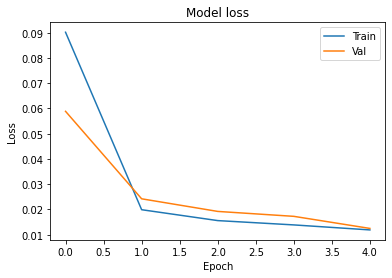

In [680]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [681]:
# performing predictions
predictions2 = model.predict(X_test2) 

# unscaling the predictions
predictions2 = scaler_y2.inverse_transform(np.array(predictions2).reshape((len(predictions2), 1)))

# printing the predictions
print('Predictions:')
predictions2[0:5]

Predictions:


array([[192.57382],
       [191.65466],
       [189.29521],
       [187.31502],
       [184.54283]], dtype=float32)

In [682]:
# calculating the training mean-squared-error
train_loss2 = model.evaluate(X_train2, y_train2, batch_size = 1)

# calculating the test mean-squared-error
test_loss2 = model.evaluate(X_test2, y_test2, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss2,4))
print('Test Loss =', round(test_loss2,4))

183/183 [==============================] - 0s 2ms/step - loss: 6.0787e-04
Train Loss = 0.0026
Test Loss = 0.0006


In [683]:
# unscaling the test feature dataset, x_test
X_test2 = scaler_x2.inverse_transform(np.array(X_test2).reshape((len(X_test2), len(cols))))

# unscaling the test y dataset, y_test
y_train2 = scaler_y2.inverse_transform(np.array(y_train2).reshape((len(y_train2), 1)))
y_test2 = scaler_y2.inverse_transform(np.array(y_test2).reshape((len(y_test2), 1)))

In [684]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test2 - predictions2),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 2.7191


In [689]:
# calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test2, predictions2)
print('Root Mean Square Error (sklearn.metrics) =', round((rmse),4))

Root Mean Square Error (sklearn.metrics) = 7.3933


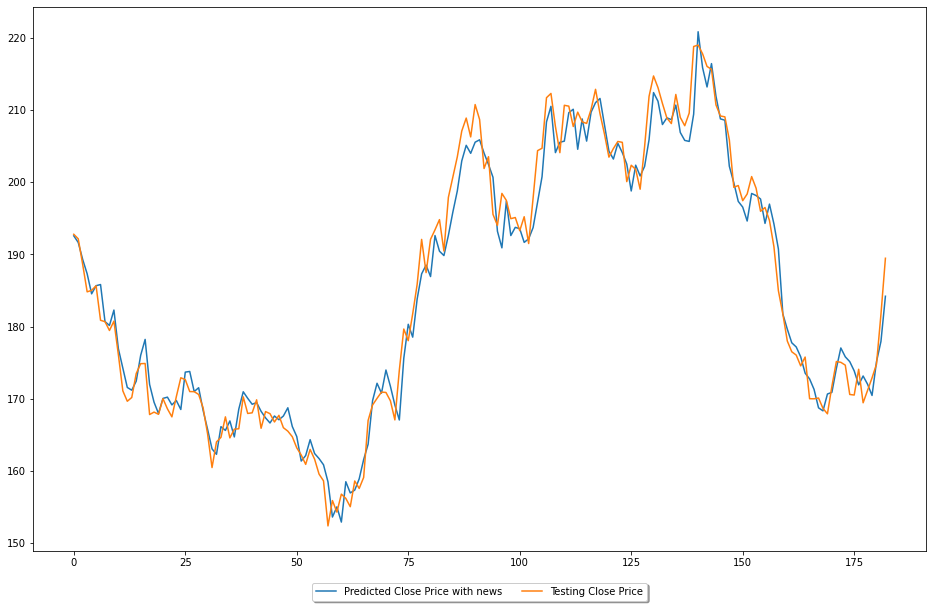

In [686]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions2, label="Predicted Close Price with news")
plt.plot([row[0] for row in y_test2], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
plt.show()

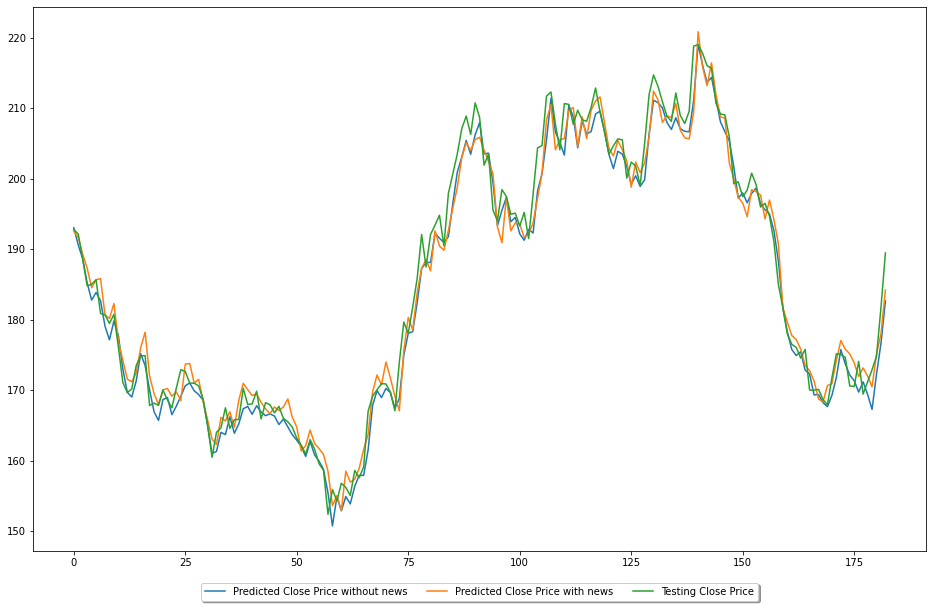

In [687]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price without news")
plt.plot(predictions2, label="Predicted Close Price with news")
plt.plot([row[0] for row in y_test2], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
plt.show()

In [688]:
df = pd.DataFrame({'Actual': y_test2.flatten(), 'Predicted': predictions2.flatten()})
df

,Actual,Predicted
0,192.79,192.573822
1,192.16,191.654663
2,188.60,189.295212
3,184.82,187.315018
4,185.03,184.542831
...,...,...
178,171.19,172.024078
179,172.91,170.473145
180,174.80,175.150650
181,181.72,177.960037
